# Term Deposit Marketing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

## Data Exploration

In [8]:
data = pd.read_csv(r'/kaggle/input/term-deposit-marketing-2020/term-deposit-marketing-2020.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
data.y.value_counts()

y
no     37104
yes     2896
Name: count, dtype: int64

In [4]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [5]:
data.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [9]:
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
numerical_cols = [col for col in data.columns if data[col].dtype != 'object']

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign']


In [10]:
data['y'] = data['y'].map({'no':0,'yes':1})

In [19]:
print('unique values for categorical features are:')
for c in categorical_cols:
  x  = data[c].unique()
  print(f'{c}: {x} -- {len(x)} values\n')

unique values for categorical features are:
job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student'] -- 12 values

marital: ['married' 'single' 'divorced'] -- 3 values

education: ['tertiary' 'secondary' 'unknown' 'primary'] -- 4 values

default: ['no' 'yes'] -- 2 values

housing: ['yes' 'no'] -- 2 values

loan: ['no' 'yes'] -- 2 values

contact: ['unknown' 'cellular' 'telephone'] -- 3 values

month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr'] -- 11 values

y: [0 1] -- 2 values



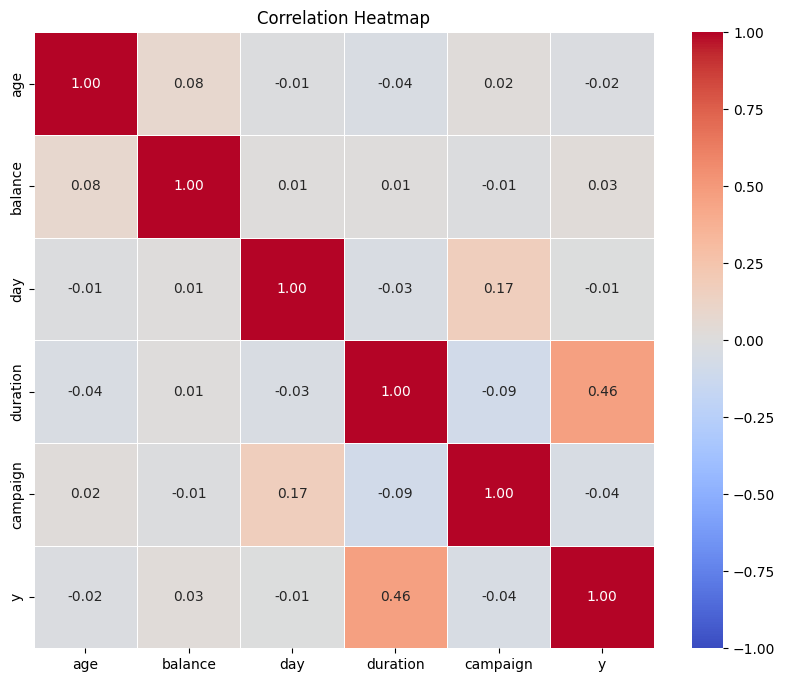

In [21]:
corr_matrix = data[numerical_cols + ['y']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title('Correlation Heatmap')
plt.show()

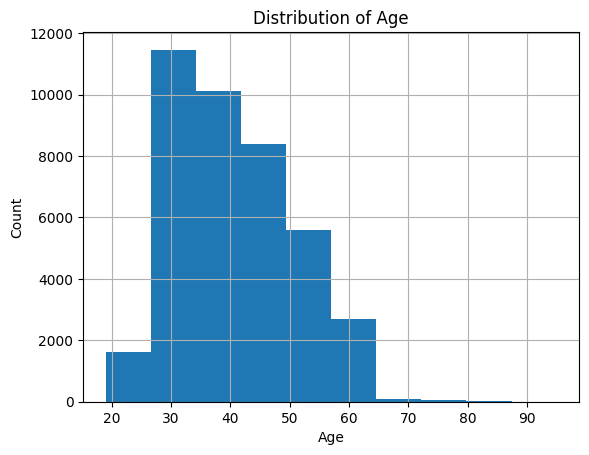

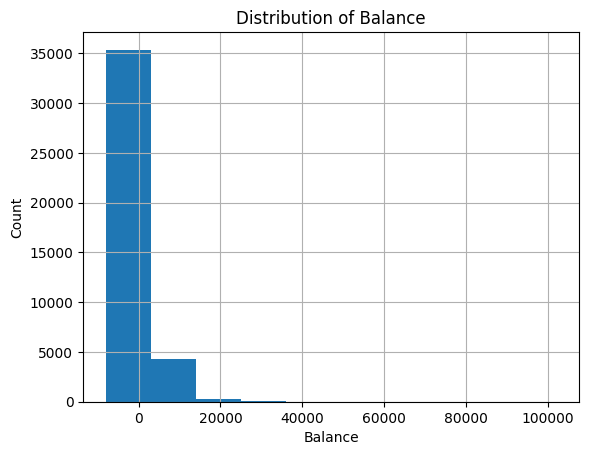

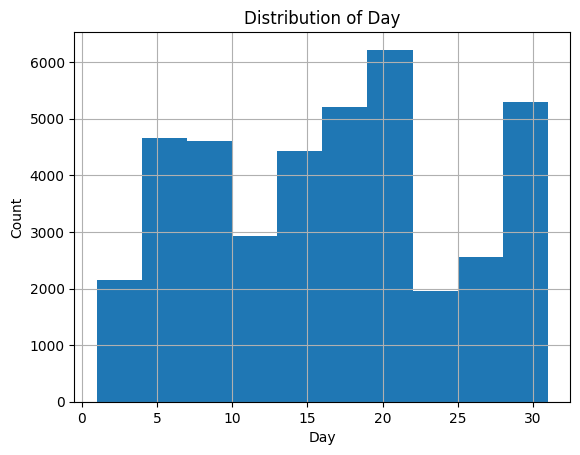

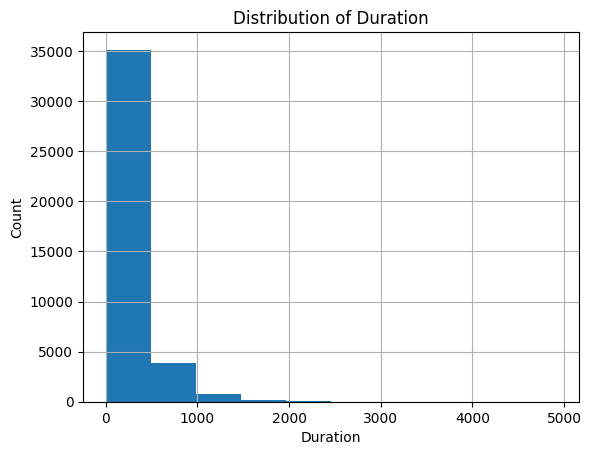

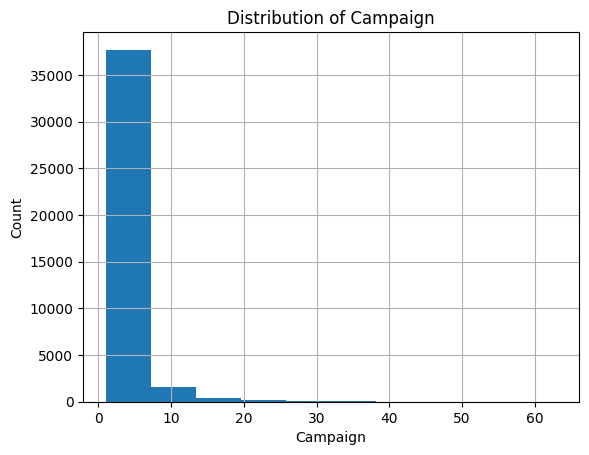

In [11]:
# Histograms for select numeric features
for col in numerical_cols[:-1]:
    plt.figure()
    data[col].hist()
    plt.title(f'Distribution of {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.show()

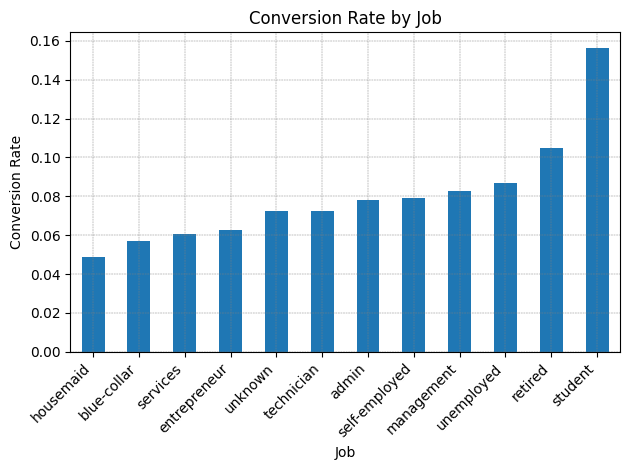

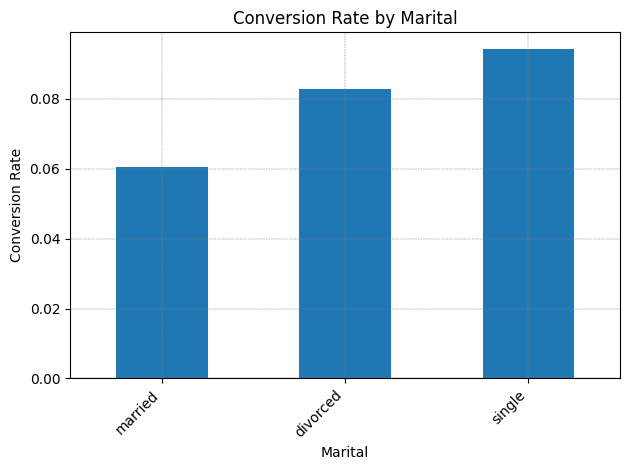

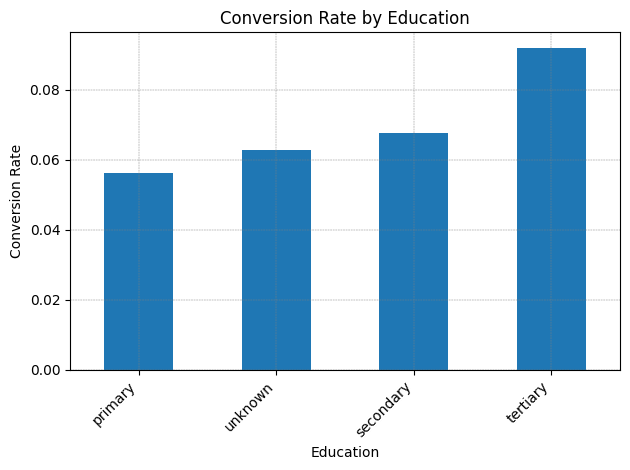

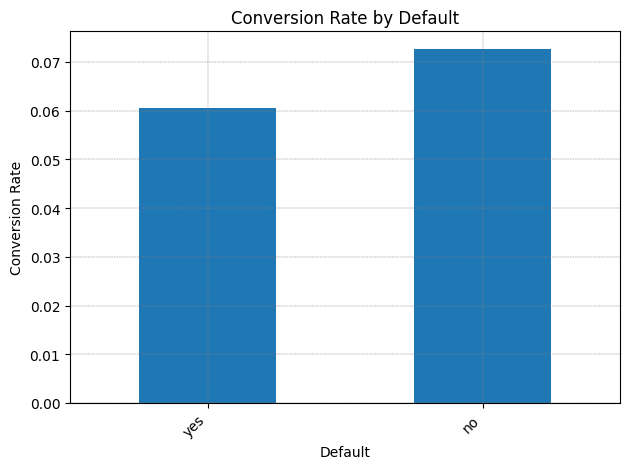

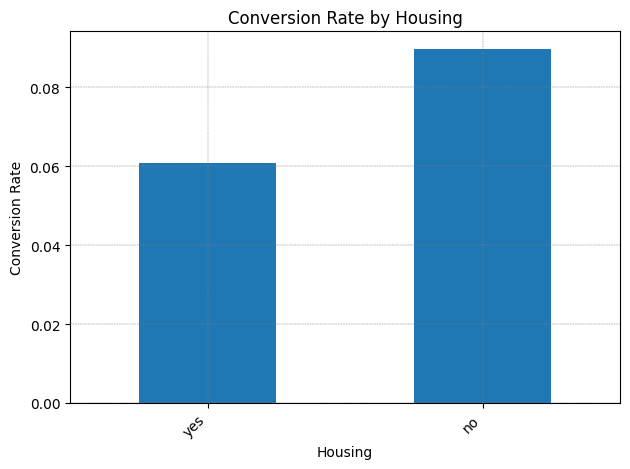

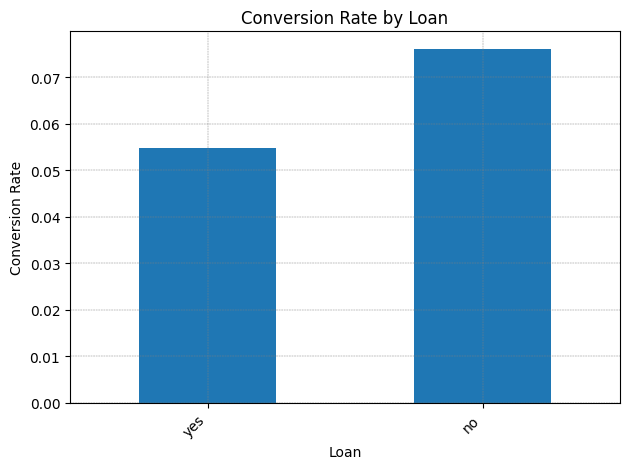

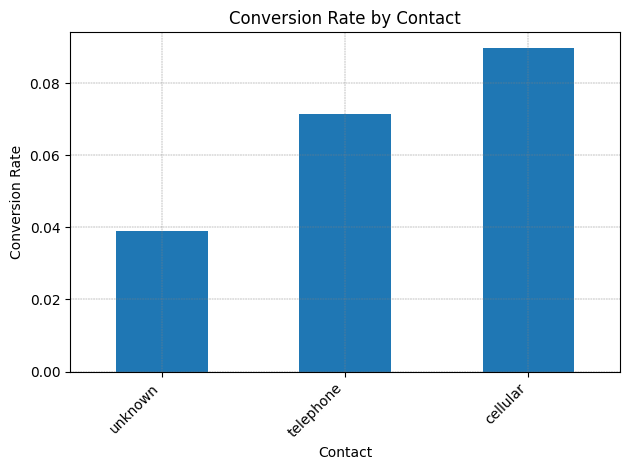

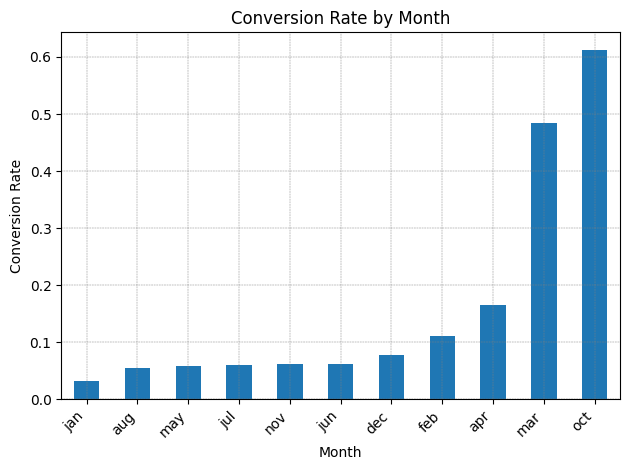

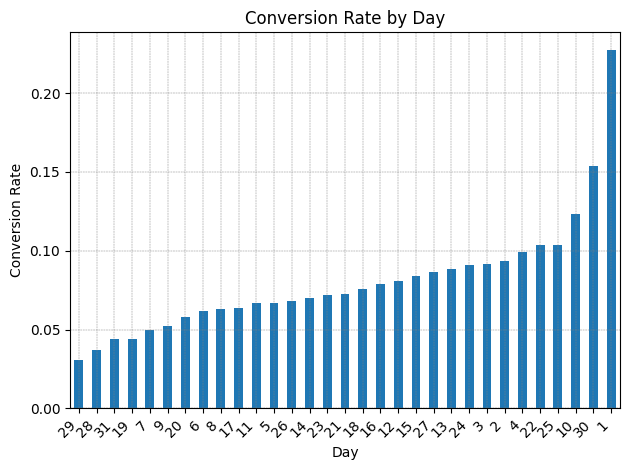

In [24]:
# Plot conversion rate for each category
for col in categorical_cols[:-1] + ['day']:
    conversion_rates = data.groupby(col)['y'].mean().sort_values()
    plt.figure()
    conversion_rates.plot(kind='bar')
    plt.title(f'Conversion Rate by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.35)
    plt.show()

#### From the intial exploration we can make a few observations: 
1. Distribution of **campaign**, **duration**, and **balance** is highly skewed
2. The data is not balanced, not many users have converted
3. Conversion is highly correlated with duration of the call made. This is natural as longer calls could mean users who are more seriously considering the offer. But won't be of much help as a guide.
4. Conversion rate is higher for students and retired users which makes sense as these are the two groups that might benefit and financially make sense for them to use a term deposit account
5. Conversion is higher for teritary education, while secondary education doesn't make much difference. In general conversion goes up with higher education
6. Loan or mortgage makes opting for deposit acount less likely which could be attributed to the less financial freedom and more need for liquidity when paying off loans
7. Conversions are significantly higher for October and March (Why?)
8. Higher conversion when last call is made first or last day of the month. Also distribution shows multiple peaks at first 5 days, 15th to 20th, and last days of the month.

## Feature Engineering & First Model

**Feature Engineering:**
* For binary variables we convert them to 0 and 1
* For month, we convert to month number, 1-12
* For education we map to numbers while keeping unknown as -1
* job, contact, and marital status will be one hot encoded
* Numerical columns like balance and duration are standard scaled

**Models:**
* We test logistic regression, random forest, and xgboost
* We use cross validation and test the final model on a hold out set to get final score

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

for col in ['default', 'housing', 'loan']:
    data[col] = data[col].map({'yes': 1, 'no': 0})
    
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
data['month'] = data['month'].map(month_map)

edu_map = {'primary': 0, 'secondary': 1, 'tertiary': 2, 'unknown': -1}
data['education'] = data['education'].map(edu_map)

data = pd.get_dummies(data, columns=['job', 'contact', 'marital'], drop_first=True)

X = data.drop(columns=['y'])
y = data['y']

X_train, X_hold, y_train, y_hold = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_hold[numerical_cols] = scaler.transform(X_hold[numerical_cols])

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=50, n_jobs=1, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=50, max_depth=3, n_jobs=1,
                                      use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Cross-validation (3-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'roc_auc']
cv_results = {}
for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    cv_results[name] = {
        'cv_accuracy_mean': scores['test_accuracy'].mean(),
        'cv_auc_mean': scores['test_roc_auc'].mean()
    }

# Hold-out evaluation
hold_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_hold)
    y_prob = model.predict_proba(X_hold)[:, 1]
    hold_results[name] = {
        'hold_accuracy': accuracy_score(y_hold, y_pred),
        'hold_auc': roc_auc_score(y_hold, y_prob)
    }

# Compile results
results_df = pd.DataFrame(cv_results).T.join(pd.DataFrame(hold_results).T)
results_df

,cv_accuracy_mean,cv_auc_mean,hold_accuracy,hold_auc
LogisticRegression,0.933344,0.904619,0.933500,0.909053
RandomForest,0.933125,0.932994,0.937250,0.933843
XGBoost,0.936469,0.946432,0.940125,0.948441
